In [1]:
from feature_calculator import FeatureCalculator
from feature_calculator import OfParams
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pims

# folder where the data is saved
rec_folder = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/")

# name of the recording
clip_name = "padel_tennis_neon_03-2ded8f56"

# load video object
vid = pims.Video(str(rec_folder / clip_name / "Neon Sensor Module v1 ps1.mp4"))

deprecated pixel format used, make sure you did set range correctly


<font size = 4>**(0) Define basic functions for loading video and computing optical flow**

In [2]:

from dataclasses import dataclass
import typing as T
import copy

def create_grid(img_shape: T.Tuple[int, int], grid_size: int) -> np.ndarray:
    x = np.linspace(0, img_shape[1], grid_size, dtype=np.float32)
    y = np.linspace(0, img_shape[0], grid_size, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    p_grid = p_grid[np.all((p_grid != 0) & (p_grid != img_shape[0]), axis=1), :]

    return p_grid


def smooth_proba(proba: np.ndarray, smooth_window) -> np.ndarray:
    proba = proba.copy()
    proba_onset = proba[:, 1]
    proba_offset = proba[:, 2]

    proba_onset = smooth_array(proba_onset, smooth_window)
    proba_offset = smooth_array(proba_offset, smooth_window)
    proba_bg = 1 - np.sum([proba_onset, proba_offset], axis=0)

    proba[:, 0] = proba_bg
    proba[:, 1] = proba_onset
    proba[:, 2] = proba_offset

    return proba


def smooth_array(ary: np.ndarray, smooth_window: int = 1):
    # Define mask and store as an array
    mask = np.ones((1, smooth_window)) / smooth_window
    mask = mask[0, :]
    # Convolve the mask with the raw data
    convolved_data = np.convolve(ary, mask, "same")
    return convolved_data


def classify(probas: np.ndarray):
    pd_labels = np.argmax(probas, axis=1)
    pd_labels[probas[:, 2] > 0.25] = 2
    pd_labels[probas[:, 1] > 0.25] = 1

    return pd_labels


@dataclass
class BlinkEvent:
    start_time: int = None
    end_time: int = None
    label: str = None


class EventArray:
    def __init__(self, start_times, end_times, labels):
        assert len(start_times) == len(end_times) == len(labels)

        self.start_times = np.asarray(start_times)
        self.end_times = np.asarray(end_times)
        self.labels = np.asarray(labels)

    @property
    def blink_events(self) -> T.List[BlinkEvent]:
        blink_label = 3
        start_times = self.start_times[self.labels == blink_label]
        end_times = self.end_times[self.labels == blink_label]
        label_name = "Blink"
        return [
            BlinkEvent(start_time, end_time, label_name)
            for start_time, end_time in zip(start_times, end_times)
        ]

    @classmethod
    def from_samples(cls, timestamps, sample_labels, mapping=None):
        """Creates an instance from a time-series of labelled samples."""
        assert len(timestamps) == len(sample_labels)
        # assert is_sorted(timestamps)

        timestamps = np.asarray(timestamps)
        sample_labels = np.asarray(sample_labels)

        now_unequal_previous = sample_labels[1:] != sample_labels[:-1]
        now_unequal_previous = np.insert(now_unequal_previous, 0, True)

        start_times = timestamps[now_unequal_previous]
        labels = sample_labels[now_unequal_previous]

        end_times = np.roll(start_times, -1)
        end_times[-1] = timestamps[-1]

        if mapping:
            labels = np.array(list(map(lambda e: mapping[e], labels)))

        return cls(start_times, end_times, labels)

    def insert_event(self, start_time: float, end_time: float, label):

        overlapping = (self.start_times < end_time) & (self.end_times > start_time)
        overlapping_ind = np.nonzero(overlapping)[0]

        assert (
            len(overlapping_ind) == 1
        ), "Currently, can insert events only in the middle of existing events, i.e. when there is only 1 overlapping event."

        # cut the overlapping event in the middle and remember end time and label
        ind = overlapping_ind[0]
        previous_end_time = self.end_times[ind]
        previous_label = self.labels[ind]

        self.end_times[ind] = start_time  # cut

        # add two new events:
        #   - the requested event at the start and end time
        #   - a "fill event" which has has the same label as the event which has been
        #   cut and which fills the t0 to the next event
        self.start_times = np.insert(self.start_times, ind + 1, [start_time, end_time])
        self.end_times = np.insert(
            self.end_times, ind + 1, [end_time, previous_end_time]
        )
        self.labels = np.insert(self.labels, ind + 1, [label, previous_label])

    def combine_same_events(self) -> None:
        """Delete events which have the same label as the previous event."""

        equal_previous = self.labels[1:] == self.labels[:-1]
        equal_previous = np.insert(equal_previous, 0, False)
        self.labels = self.labels[~equal_previous]
        self.start_times = self.start_times[~equal_previous]

        # reconstruct end times from start times
        final_time = self.end_times[-1]
        self.end_times = np.roll(self.start_times, -1)
        self.end_times[-1] = final_time

    def remove_events(self, del_mask) -> None:
        # remember boundaries of time axis (start and end times of first and last event)
        initial_time = self.start_times[0]
        final_time = self.end_times[-1]

        # filter events
        self.labels = self.labels[~del_mask]
        self.start_times = self.start_times[~del_mask]

        self.combine_same_events()

        # fix events at the boundaries (if first or last event were removed)
        # last event must stop at the end of the time axis
        self.end_times[-1] = final_time
        # first event must start at the first samples
        self.start_times[0] = initial_time

    @property
    def duration_s(self):
        return self.end_times - self.start_times

    def copy(self):
        """Returns a copied instance of this object."""
        start_times = copy.deepcopy(self.start_times)
        end_times = copy.deepcopy(self.end_times)
        labels = copy.deepcopy(self.labels)
        return EventArray(start_times, end_times, labels)


def filter_wrong_sequence(array: EventArray, max_gap_duration_s=None) -> EventArray:
    none_idx = np.where(array.labels == 0)[0]
    onset_idx = np.where(array.labels == 1)[0]
    offset_idx = np.where(array.labels == 2)[0]

    keep_onset_idx = list(set(onset_idx) & set(offset_idx - 1))
    keep_offset_idx = [i + 1 for i in keep_onset_idx]

    # Discard blink events with long gap between onset and offset
    if max_gap_duration_s is not None:
        onset_idx_gap = list(set(onset_idx) & set(none_idx - 1) & set(offset_idx - 2))
        if onset_idx_gap:
            onset_idx_gap = np.asarray(onset_idx_gap)
            none = onset_idx_gap + 1
            onset_idx_gap = onset_idx_gap[array.duration_s[none] < max_gap_duration_s]
            keep_onset_idx += onset_idx_gap.tolist()
            keep_offset_idx += [i + 2 for i in onset_idx_gap]

    filtered_array = EventArray([array.start_times[0]], [array.end_times[-1]], [0])
    for start_time, end_time in zip(
        array.start_times[keep_onset_idx], array.end_times[keep_offset_idx]
    ):
        filtered_array.insert_event(start_time, end_time, 3)
    return filtered_array


def filter_short_events(
    array: EventArray, min_len_s: float, select_label
) -> EventArray:
    """Remove short blinks from the sequence."""

    filtered_array = array.copy()
    mask_on = filtered_array.labels == select_label
    mask_short = filtered_array.duration_s < min_len_s
    del_mask = mask_on & mask_short
    filtered_array.remove_events(del_mask)
    return filtered_array


<font size = 5>**(1) Calculate optical flow fields for each frame** <br><br>
<font size = 3>Compute optical flow fields using the the Lucas-Kanade method as implemented in OpenCV, on 4x4 grid points<br>
Optical flow vectors are computed separately for left and right video frames and then concatenated.

In [3]:
# define optical flow parameters
of_params = OfParams(n_layers=5, layer_interval=7, average=False, img_shape=(64, 64), grid_size=4, step_size=7, window_size=15, stop_steps=3)

# define grid for optical flow calculation
grid = create_grid(of_params.img_shape, of_params.grid_size + 2)

# initialize feature calculator object
feature_calculator = FeatureCalculator(vid, of_params, grid)

# calculate optical flow for each frame (feature_calculator.of_array)
# (returns only y component of optical flow)
feature_calculator.calculate_optical_flow()

<font size = 3>Plot mean optical flow for a given time interval

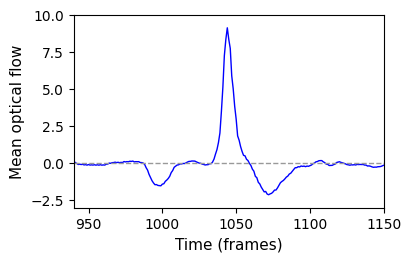

In [43]:
fig, ax = plt.subplots(figsize=(4, 2.5))

mean_optical_flow = np.mean(feature_calculator.of_array, axis=1)
ax.plot(mean_optical_flow, color='blue', linewidth=1)

# Set axis labels and limits
ax.set_xlabel('Time (frames)', fontsize=11)
ax.set_ylabel('Mean optical flow', fontsize=11)
ax.set_xlim(940, 1150)
ax.set_ylim(-3, 10)

# Add horizontal line at y=0
ax.axhline(0, color=[.6, .6, .6], linestyle='--', linewidth=1)

<font size = 5>**(2) Create feature vector** <br><br>
<font size = 3>A feature vector is constructed containing the optical flow associated with the current,<br> 
as well as preceding as well as subsequent frames. More specifically, the optical flow vectors<br> 
across multiple points in time (in the following: “layers”) are concatenated,<br>
with a given number of layers (n_layers = 5) and a temporal interval between the layers<br> 
(layer_interval = 7 frames, corresponding to a time difference of 35 ms).<br><br>

The number of features is given by: n_layers (5) * n_grid_points (16) * 2 (left + right) = 160

In [44]:
n_layers = 5
layer_interval = 7

feature_calculator.concatenate_optical_flow(n_layers, layer_interval)

print("Number of features: {}".format(feature_calculator.feature_array.shape[1]))

Number of features: 160


<font size = 5>**(3) Feed into classifier** <br><br>
<font size = 3>The feature vectors are submitted to the pre-trained XGBoost classifier to generate a time-series of class probabilities.<br>
The three classes are: (1) Background (2) Blink onset (eyelid closing) and (3) Blink offset (eyelid reopening)<br><br>
<font size = 3>Load trained XGBoost classifier:

In [46]:
import joblib

# path to trained classifier
clf_path = "/users/tom/git/neon_blink_detection/weights/xgb.sav"
# load pre-trained classifier
clf = joblib.load(clf_path)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='approx', use_label_encoder=False,
              validate_parameters=1, ...)

<font size = 3>Obtain frame-wise class probabilities:

In [47]:
probas = clf.predict_proba(feature_calculator.feature_array)

<font size = 5>**(4) Temporal smoothing** <br><br>
<font size = 3>Runing average with kernel size of 11 frames.

In [49]:
kernel_size = 11
smoothed_proba = smooth_proba(probas, kernel_size)

<font size = 3>Plot blink onset and offset probabilities before and after smoothing 

(940.0, 1150.0)

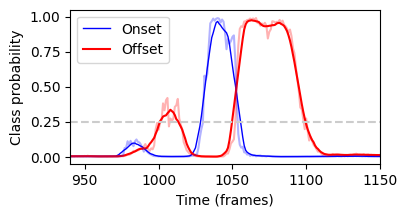

In [117]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))

ax.plot(smoothed_proba[:, 1], color="blue", lw=1)
ax.plot(smoothed_proba[:, 2], color="red")
ax.plot(probas[:, 1], color="blue", alpha=0.3)
ax.plot(probas[:, 2], color="red", alpha=0.3)

# horizontal line at 0.25
ax.axhline(0.25, color=[.8, .8, .8], linestyle="--")

ax.set_xlabel("Time (frames)")
ax.set_ylabel("Class probability")
ax.legend(["Onset",  "Offset"])
ax.set_xlim(940, 1150)

<font size = 5>**(5) Discretization** <br><br>
<font size = 3>Turns class probabilities into discrete class predictions.

In [52]:
prediction = classify(smoothed_proba)

<font size = 5>**(6) Conversion to events** <br><br>
<font size = 3>Consecutive frames classified as blink onsets or blink offsets are compiled into blink onset or blink offset events,<br>
each defined by its type (onset or offset) as well as a start and end time. The obtained event series is submitted to a post-processing<br> 
procedure that exploits the stereotypical sequence of eyelid closing and reopening inherent to eye blinks,<br>
as well as other temporal characteristics (total blink duration as well as the temporal lag between blink onset and offset).

<font size = 4>**(6.1) Filter wrong sequence**<br><br>
<font size = 3>Remove events where the order of events is incorrect, e.g. blink offsets preceding onsets or isolated offset/onset events

In [54]:
# if gap between onset and offset event is longer than 30 ms, discard the event
max_gap_duration_s = 0.03
timestamps = np.arange(0, len(prediction)) / 200

# create event array
event_array_pd = EventArray.from_samples(timestamps, prediction)

# filter wrong sequence (e.g. onset without offset) and events with long gap
blink_array_pd = filter_wrong_sequence(event_array_pd, max_gap_duration_s)

<font size = 4>**(6.2) Filter short events**<br><br>
<font size = 3>Remove blinks that are shorter than 100 ms.

In [95]:
# define minimum blink duration
min_len_s = 0.1
# define label for blink events
blink_label = 3

# filter short blinks
blink_array_pd = filter_short_events(blink_array_pd, min_len_s, blink_label)

# get blink events
blink_events = blink_array_pd.blink_events

[BlinkEvent(start_time=0.805, end_time=1.12, label='Blink'),
 BlinkEvent(start_time=5.145, end_time=5.5, label='Blink'),
 BlinkEvent(start_time=6.22, end_time=6.52, label='Blink'),
 BlinkEvent(start_time=7.0, end_time=7.33, label='Blink'),
 BlinkEvent(start_time=7.545, end_time=7.815, label='Blink')]

<font size = 3>**Plot mean optical flow and predicted blink events**

Text(0.5, 1.0, 'Example blink #2')

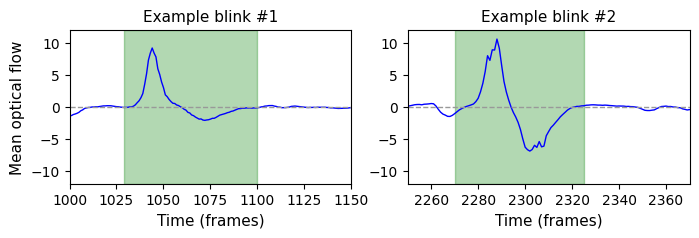

In [113]:
mean_of = np.mean(feature_calculator.of_array, axis=1)

f, ax = plt.subplots(1, 2, figsize=(8, 2))

ax[0].plot(mean_of, color="blue", lw=1)
ax[0].axhline(0, color=[.6, .6, .6], linestyle="--", linewidth=1)

# plot blink events as horizontal lines
for iblink in range(len(blink_events)):
    start = blink_events[iblink].start_time * 200
    end = blink_events[iblink].end_time * 200
    ax[0].axvspan(start, end, color="green", alpha=0.3)

ax[0].set_xlim(1000, 1150)
ax[0].set_ylim(-12, 12)
ax[0].set_xlabel("Time (frames)", fontsize=11)
ax[0].set_ylabel("Mean optical flow", fontsize=11)
ax[0].set_title("Example blink #1", fontsize=11)

ax[1].plot(mean_of, color="blue", lw=1, label='_Hidden label')
ax[1].axhline(0, color=[.6, .6, .6], linestyle="--", linewidth=1)

# plot blink events as horizontal lines
for iblink in range(len(blink_events)):
    start = blink_events[iblink].start_time * 200
    end = blink_events[iblink].end_time * 200
    ax[1].axvspan(start, end, color="green", alpha=0.3)

ax[1].set_xlim(2250, 2370)
ax[1].set_ylim(-12, 12)
ax[1].set_xlabel("Time (frames)", fontsize=11)
ax[1].set_title("Example blink #2", fontsize=11)


In [120]:
path = Path("/users/tom/git/neon_blink_detection/output/export-OpticalFlowCNN-180420231007/n_lay5-lay_intv7-grid4-win15-step7-subtract_meanFalse/train_loss-0.npy")

train_loss = np.load(path)

path = Path("/users/tom/git/neon_blink_detection/output/export-OpticalFlowCNN-180420231007/n_lay5-lay_intv7-grid4-win15-step7-subtract_meanFalse/val_loss-0.npy")

val_loss = np.load(path)



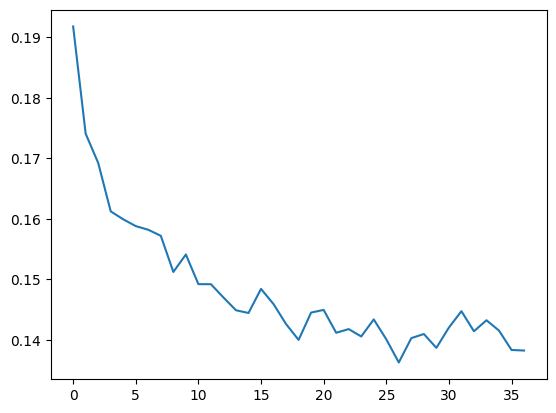

In [122]:
plt.plot(val_loss, label="val")